# Description

This notebook contains the interpretation of a cluster (which features/latent variables in the original data are useful to distinguish traits in the cluster).

See section [LV analysis](#lv_analysis) below

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from IPython.display import HTML
from tqdm import tqdm

from clustering.methods import ClusterInterpreter
from data.recount2 import LVAnalysis
from data.cache import read_data
import conf

# Settings

In [3]:
# PARTITION_K = 26
# PARTITION_CLUSTER_ID = 18

# Load MultiPLIER summary

In [4]:
multiplier_model_summary = read_data(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [5]:
multiplier_model_summary.shape

(2157, 5)

In [6]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3752, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## Clustering partitions

In [13]:
CONSENSUS_CLUSTERING_DIR = Path(
    conf.RESULTS["CLUSTERING_DIR"], "consensus_clustering"
).resolve()

display(CONSENSUS_CLUSTERING_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/consensus_clustering')

In [14]:
input_file = Path(CONSENSUS_CLUSTERING_DIR, "best_partitions_by_k.pkl").resolve()
display(input_file)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/consensus_clustering/best_partitions_by_k.pkl')

In [15]:
best_partitions = pd.read_pickle(input_file)

In [16]:
best_partitions.shape

(59, 4)

In [17]:
best_partitions.head()

,method,partition,ari_median,selected
k,,,,
11,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090231,True
13,scc_025,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.090222,True
14,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090138,True
22,scc_020,"[1, 19, 19, 19, 19, 19, 19, 19, 19, 1, 19, 19,...",0.090117,True
12,scc_025,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",0.089742,True


# Functions

In [18]:
def show_cluster_stats(data, partition, cluster):
    cluster_traits = data[partition == cluster].index
    display(f"Cluster '{cluster}' has {len(cluster_traits)} traits")
    display(cluster_traits)

# LV analysis
<a id="lv_analysis"></a>

## Associated traits

In [19]:
# display(best_partitions.loc[PARTITION_K])
# part = best_partitions.loc[PARTITION_K, "partition"]

In [20]:
# show_cluster_stats(data, part, PARTITION_CLUSTER_ID)

## Associated latent variables

In [21]:
# ci = ClusterInterpreter(
#     threshold=1.0,
#     max_features=20,
#     max_features_to_explore=100,
# )

In [22]:
# ci.fit(data, part, PARTITION_CLUSTER_ID)

In [23]:
# ci.features_

In [24]:
# # save interpreter instance
# output_dir = Path(
#     conf.RESULTS["CLUSTERING_INTERPRETATION"]["BASE_DIR"],
#     "cluster_lvs",
#     f"part{PARTITION_K}",
# )
# output_dir.mkdir(exist_ok=True, parents=True)

In [25]:
# output_file = Path(
#     output_dir, f"cluster_interpreter-part{PARTITION_K}_k{PARTITION_CLUSTER_ID}.pkl"
# )
# display(output_file)

In [26]:
# ci.features_.to_pickle(output_file)

## Top attributes

In [27]:
# lvs_list = "LV116,LV931,LV744,LV697,LV885,LV536,LV550,LV220,LV272,LV739,LV678,LV470,LV66,LV189,LV517,LV840,LV246,LV502,LV525,LV85".split(",")

In [28]:
lvs_list = pd.read_pickle("/tmp/lv_list.pkl").index.tolist()

In [29]:
len(lvs_list)

485

In [30]:
lvs_list[:10]

['LV116',
 'LV931',
 'LV744',
 'LV697',
 'LV885',
 'LV536',
 'LV550',
 'LV220',
 'LV272',
 'LV739']

In [31]:
def _my_func(x):
    _cols = [c for c in x.index if not c.startswith("LV")]
    _tmp = x[_cols].dropna()
    if _tmp.shape[0] > 0:
        return _tmp.iloc[0]

    return None

In [32]:
cell_type_dfs = []
tissue_dfs = []

pbar = tqdm(lvs_list[:50])
for lv_name in pbar:
    pbar.set_description(lv_name)

#     lv_name = lv_info["name"]
    lv_obj = LVAnalysis(lv_name, data)

#     # show lv prior knowledge match (pathways)
#     lv_pathways = multiplier_model_summary[
#         multiplier_model_summary["LV index"].isin((lv_name[2:],))
#         & (
#             (multiplier_model_summary["FDR"] < 0.05)
#             | (multiplier_model_summary["AUC"] >= 0.75)
#         )
#     ]
#     display(lv_pathways)

    lv_data = lv_obj.get_experiments_data()

#     display("")
#     display(lv_obj.lv_traits.head(20))
#     display("")
#     display(lv_obj.lv_genes.head(10))

    # get cell type attributes
#     lv_attrs = lv_obj.get_attributes_variation_score()
    lv_attrs = pd.Series(lv_data.columns.tolist())
    lv_attrs = lv_attrs[
        lv_attrs.str.match(
            "(?:cell[^\w]*type$)",
            case=False,
            flags=re.IGNORECASE,
        ).values
    ].sort_values(ascending=False)
    display(lv_attrs)
    
    lv_attrs_data = lv_data[lv_attrs.tolist() + [lv_name]]
    lv_attrs_data = lv_attrs_data.assign(attr=lv_attrs_data.apply(_my_func, axis=1))
    lv_attrs_data = lv_attrs_data.drop(columns=lv_attrs.tolist())
    lv_attrs_data = lv_attrs_data.dropna().sort_values(lv_name, ascending=False)
    lv_attrs_data = lv_attrs_data.rename(columns={lv_name: "lv"})
    cell_type_dfs.append(lv_attrs_data)
    
    # get tissue attributes
    lv_attrs = pd.Series(lv_data.columns.tolist())
    lv_attrs = lv_attrs[
        lv_attrs.str.match(
            "(?:tissue$)|(?:tissue[^\w]*type$)",
            case=False,
            flags=re.IGNORECASE,
        ).values
    ].sort_values(ascending=False)
    display(lv_attrs)
    
    lv_attrs_data = lv_data[lv_attrs.tolist() + [lv_name]]
    lv_attrs_data = lv_attrs_data.assign(attr=lv_attrs_data.apply(_my_func, axis=1))
    lv_attrs_data = lv_attrs_data.drop(columns=lv_attrs.tolist())
    lv_attrs_data = lv_attrs_data.dropna().sort_values(lv_name, ascending=False)
    lv_attrs_data = lv_attrs_data.rename(columns={lv_name: "lv"})
    tissue_dfs.append(lv_attrs_data)

LV116:   0%|          | 0/50 [00:00<?, ?it/s]

SRP059039, SRP045500, SRP063059, SRP045569, SRP015670, SRP059531, SRP062958, SRP039361, SRP056733, SRP060370, SRP062966, SRP045352, SRP048804, SRP032775, SRP059172, SRP050246, SRP064458, SRP033711, SRP049820, SRP023199, SRP060416, SRP005279, SRP042161, SRP059701, SRP068139, SRP051848, SRP014428, SRP063661, SRP057205, SRP041826, SRP059057, SRP064259, SRP046226, SRP044956, SRP066356, SRP048640, SRP041885, SRP045659, SRP041647, SRP045565, SRP041620, SRP053186, SRP045441, SRP022133, SRP055874, SRP029990, SRP044206, SRP065763, SRP056443, SRP041538, SRP044593, SRP019270, SRP067934, SRP059035, SRP019936, SRP054971, SRP058237, SRP051368, SRP019758, 

8      celltype
21    cell type
dtype: object

79    tissue type
4          tissue
dtype: object

LV931:   2%|▏         | 1/50 [00:12<10:23, 12.72s/it]

SRP056295, SRP017138, SRP043080, SRP048759, SRP021191, SRP028594, SRP056197, SRP050272, SRP059735, SRP028554, SRP061932, SRP033266, SRP005279, SRP055390, SRP050493, SRP046233, SRP035679, SRP043033, SRP041885, SRP027358, SRP045500, SRP045352, SRP015360, SRP053046, 

30     celltype
1     cell type
dtype: object

0    tissue
dtype: object

LV744:   4%|▍         | 2/50 [00:18<08:26, 10.55s/it]

SRP033135, SRP002326, SRP042161, SRP066834, SRP055569, SRP060416, SRP020646, SRP013363, SRP050499, SRP057196, SRP012461, SRP013935, SRP059379, SRP062177, SRP007338, SRP003901, SRP033248, SRP028902, SRP014688, SRP057205, SRP011422, SRP040278, SRP050992, SRP055153, SRP002184, SRP042218, SRP053246, SRP007461, SRP009276, SRP007947, SRP036821, SRP058351, SRP018716, SRP043085, SRP019994, SRP059035, SRP006575, SRP010350, SRP007596, SRP026537, SRP002487, SRP015819, SRP012056, SRP064464, SRP039348, SRP008218, SRP021072, SRP028170, SRP018525, SRP041718, SRP052706, SRP037719, SRP042297, SRP059057, SRP010907, SRP041036, SRP059775, SRP063840, SRP016568, SRP051599, SRP044766, SRP006474, SRP036053, SRP007525, SRP018838, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (64 != 65)
  warnings.warn(


0    cell type
dtype: object

7    tissue
dtype: object

LV697:   6%|▌         | 3/50 [00:35<09:44, 12.45s/it]

SRP051083, SRP048700, SRP055569, SRP043960, SRP041846, SRP057196, SRP055153, SRP051595, SRP044668, SRP042161, SRP060416, SRP013935, SRP062332, SRP061425, SRP066363, SRP033135, SRP031459, SRP051485, SRP038963, SRP044013, SRP059035, SRP051606, SRP004637, SRP064259, SRP006912, SRP045421, SRP050440, SRP056153, SRP056530, SRP040692, SRP066956, SRP009247, SRP019240, SRP028902, SRP056498, SRP063493, SRP060708, SRP059379, SRP007461, SRP017411, SRP060370, SRP051544, SRP066834, SRP041956, SRP063840, SRP032456, SRP042184, SRP007498, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (47 != 48)
  warnings.warn(


7    cell type
dtype: object

13    tissue type
9          tissue
dtype: object

LV885:   8%|▊         | 4/50 [00:47<09:29, 12.38s/it]

SRP058667, SRP060355, SRP007338, SRP024268, SRP036848, SRP035387, SRP045276, SRP019807, SRP007508, SRP029889, SRP028336, SRP058626, SRP015640, SRP057248, SRP064464, SRP057196, SRP049097, SRP063840, SRP009123, SRP055569, SRP050551, SRP050499, SRP014635, SRP059950, SRP064259, SRP009862, SRP042161, SRP064454, SRP066834, SRP049333, SRP052950, SRP060416, SRP044917, SRP051249, SRP007498, SRP003901, SRP051485, SRP030401, SRP007881, SRP029603, SRP040998, SRP011578, SRP019810, SRP050003, SRP009247, SRP026620, SRP033135, SRP051472, SRP066956, SRP029262, SRP051705, SRP061701, SRP012167, SRP057244, SRP026454, SRP040442, SRP041377, SRP051822, SRP059035, SRP055438, SRP016583, SRP006575, SRP057586, SRP014027, SRP042620, SRP015668, SRP010279, SRP014213, SRP056696, SRP027364, SRP037982, SRP001997, SRP051825, SRP057205, SRP007412, SRP052057, SRP058722, SRP018853, SRP016140, SRP059775, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (78 != 80)
  warnings.warn(


24    cell type
dtype: object

0    tissue type
3         tissue
dtype: object

LV536:  10%|█         | 5/50 [01:04<10:17, 13.73s/it]

SRP007947, SRP003901, SRP055569, SRP037722, SRP008218, SRP066834, SRP015013, SRP060416, SRP019994, SRP057196, SRP042161, SRP058773, SRP012557, SRP050499, SRP055153, SRP059379, SRP030617, SRP005279, SRP051606, SRP003754, SRP058841, SRP009247, SRP050497, SRP018104, SRP007508, SRP008145, SRP041377, SRP002326, SRP035478, SRP033135, SRP017777, SRP055440, SRP057248, SRP000599, SRP013450, SRP014213, SRP055513, SRP042218, SRP034543, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (37 != 39)
  warnings.warn(


0    cell type
dtype: object

3    tissue
dtype: object

LV550:  12%|█▏        | 6/50 [01:16<09:43, 13.27s/it]

SRP055569, SRP033135, SRP051606, SRP009247, SRP057196, SRP066834, SRP060416, SRP012557, SRP049097, SRP019994, SRP042161, SRP017933, SRP065559, SRP058773, SRP007498, SRP012461, SRP050497, SRP019807, SRP041396, SRP019936, SRP030617, SRP055438, SRP050499, SRP045352, SRP042620, SRP055153, SRP055810, SRP051825, SRP064464, SRP018853, SRP055392, SRP002184, SRP009266, SRP063840, SRP006474, SRP015845, SRP026315, SRP059733, SRP048820, SRP036848, SRP059035, SRP034007, SRP015013, SRP011578, SRP058667, SRP009862, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (43 != 46)
  warnings.warn(


0    cell type
dtype: object

17    tissue type
10         tissue
dtype: object

LV220:  14%|█▍        | 7/50 [01:32<10:01, 13.99s/it]

SRP042161, SRP060416, SRP050499, SRP055569, SRP033135, SRP066834, SRP059379, SRP057196, SRP009266, SRP003901, SRP018838, SRP055153, SRP011546, SRP064464, SRP063840, SRP059775, SRP015449, SRP050992, SRP059035, SRP049238, SRP047192, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (20 != 21)
  warnings.warn(


1    cell type
dtype: object

14    tissue
dtype: object

LV272:  16%|█▌        | 8/50 [01:44<09:26, 13.48s/it]

SRP055569, SRP042161, SRP006474, SRP033135, SRP017575, SRP036821, SRP006575, SRP057196, SRP009266, SRP050499, SRP066834, SRP065202, SRP019994, SRP060416, SRP047192, SRP005279, SRP059775, SRP049097, SRP059379, SRP058773, SRP007359, SRP061241, SRP012461, SRP009862, SRP042620, SRP049713, SRP014620, SRP057745, SRP003754, SRP033369, SRP033276, SRP014428, SRP027383, SRP049238, SRP045322, SRP062230, SRP024268, SRP058841, SRP018838, SRP002915, SRP055810, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (38 != 41)
  warnings.warn(


0    cell type
dtype: object

33    tissue type
12         tissue
dtype: object

LV739:  18%|█▊        | 9/50 [01:57<09:13, 13.49s/it]

SRP042161, SRP066834, SRP059379, SRP009862, SRP057196, SRP062025, SRP063840, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (6 != 7)
  warnings.warn(


1    cell type
dtype: object

5    tissue
dtype: object

LV678:  20%|██        | 10/50 [02:03<07:27, 11.20s/it]

SRP011924, SRP066729, SRP055569, SRP052978, SRP029889, SRP026315, SRP042161, SRP017933, SRP009266, SRP033135, SRP009862, SRP014428, SRP006475, SRP055810, SRP062177, SRP034712, SRP028301, SRP044206, SRP012056, SRP057196, SRP057118, SRP045573, SRP024268, SRP018838, SRP060416, SRP018719, SRP061888, SRP058840, SRP002915, SRP059775, SRP014867, SRP033276, SRP029899, SRP021478, SRP049500, SRP036821, SRP055513, SRP058773, SRP045666, SRP041706, SRP011185, SRP006575, SRP028336, SRP043368, SRP012461, SRP058740, SRP007947, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (45 != 47)
  warnings.warn(


2    cell type
dtype: object

0    tissue
dtype: object

LV470:  22%|██▏       | 11/50 [02:15<07:23, 11.38s/it]

SRP024268, SRP007947, SRP064464, SRP057196, SRP066834, SRP055569, SRP060416, SRP007412, SRP041036, SRP029889, SRP042161, SRP058667, SRP039361, SRP060355, SRP007338, SRP045276, SRP015976, SRP028336, SRP056696, SRP042620, SRP014428, SRP055513, SRP063840, SRP006575, SRP050499, SRP012015, SRP061701, SRP045569, SRP033135, SRP047192, SRP059066, SRP063834, SRP058773, SRP037982, SRP064259, SRP017138, SRP059379, SRP041826, SRP050003, SRP020493, SRP050551, SRP010483, SRP012461, SRP035387, SRP039694, SRP001558, SRP009247, SRP011924, SRP066956, SRP040998, SRP056098, SRP052740, SRP058626, SRP034712, SRP062873, SRP004837, SRP025982, SRP042218, SRP051688, SRP063661, SRP049591, SRP009373, SRP003901, SRP043960, SRP045898, SRP056395, SRP030617, SRP007461, SRP066356, SRP051485, SRP045659, SRP011546, SRP050992, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (71 != 73)
  warnings.warn(


4    cell type
dtype: object

24    tissue type
0          tissue
dtype: object

LV66:  24%|██▍       | 12/50 [02:39<09:36, 15.18s/it] 

SRP048674, SRP029207, SRP021912, SRP051249, SRP040292, SRP055513, SRP055569, SRP057196, SRP050499, SRP017959, SRP029334, SRP045364, SRP043434, SRP049981, SRP042161, SRP008218, SRP020646, SRP011895, SRP012461, SRP021193, SRP012656, SRP026052, SRP050954, SRP037982, SRP049946, SRP027383, SRP022259, SRP049409, SRP056696, SRP018933, SRP002915, SRP033135, SRP009123, SRP058804, SRP043221, SRP066834, SRP050193, SRP048759, SRP047192, SRP050551, SRP008145, SRP060416, SRP044610, SRP050992, SRP004637, SRP044668, SRP057205, SRP058773, SRP042218, SRP016059, SRP058740, SRP040300, SRP020493, SRP039694, SRP040998, SRP058375, SRP056146, SRP010054, SRP039591, SRP019994, SRP014790, SRP014213, SRP007338, SRP029262, SRP014809, SRP018403, SRP041538, SRP063834, SRP034592, SRP018838, SRP007494, SRP050374, SRP002326, SRP007481, SRP030617, SRP026620, SRP052879, SRP015013, SRP033351, SRP058626, SRP061566, SRP039338, SRP017435, SRP044042, SRP015853, SRP007461, SRP007498, SRP003726, SRP066371, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (86 != 89)
  warnings.warn(


1    cell type
dtype: object

38    tissue type
2          tissue
dtype: object

LV189:  26%|██▌       | 13/50 [02:57<09:52, 16.00s/it]

SRP037775, SRP064259, SRP033250, SRP026537, SRP045322, SRP042620, SRP042161, SRP055569, SRP049500, SRP006575, SRP030475, SRP011974, SRP049507, SRP030401, SRP043470, SRP057205, SRP061241, SRP055512, SRP059379, SRP058722, SRP063620, SRP049988, SRP019498, SRP060416, SRP057196, SRP065202, SRP033135, SRP018853, SRP011054, SRP019936, SRP013389, SRP063840, SRP066834, SRP032789, SRP048664, SRP040966, SRP047192, SRP061243, SRP004637, SRP012557, SRP040418, SRP023262, SRP044610, SRP058571, SRP055153, SRP051102, SRP031503, SRP058773, SRP012167, SRP043320, SRP035988, SRP067214, SRP049713, SRP040505, SRP050971, SRP057758, SRP013239, SRP029334, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (56 != 58)
  warnings.warn(


2    cell type
dtype: object

51    tissue type
8          tissue
dtype: object

LV517:  28%|██▊       | 14/50 [03:10<09:05, 15.16s/it]

SRP055569, SRP057196, SRP015449, SRP002326, SRP042161, SRP060416, SRP033206, SRP030401, SRP025989, SRP050892, SRP040421, SRP012461, SRP064259, SRP050499, SRP009266, SRP018104, SRP005279, SRP066834, SRP006970, SRP057205, SRP029889, SRP019994, SRP018020, SRP043960, SRP009862, SRP017199, SRP058773, SRP014624, SRP018838, SRP015976, SRP060359, SRP014867, SRP033119, SRP059775, SRP014320, SRP063840, SRP041788, SRP056696, SRP017575, SRP018719, SRP027345, SRP017933, SRP046266, SRP030617, SRP015670, SRP015013, SRP044206, SRP017190, SRP055863, SRP011422, SRP007338, SRP015678, SRP045639, SRP006575, SRP028325, SRP033135, SRP059039, SRP004837, SRP059732, SRP062389, SRP059379, SRP014428, SRP002605, SRP023262, SRP027258, SRP036821, SRP010038, SRP038964, SRP041162, SRP014027, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (67 != 70)
  warnings.warn(


0    cell type
dtype: object

1    tissue
dtype: object

LV840:  30%|███       | 15/50 [03:27<09:07, 15.65s/it]

SRP043417, SRP028301, SRP059775, SRP062177, SRP012056, SRP033119, SRP040278, SRP058300, SRP034543, SRP056084, SRP038695, SRP058841, SRP059948, SRP042161, SRP009266, SRP006475, SRP045501, SRP033369, SRP058773, SRP018861, SRP041036, SRP055810, SRP055569, SRP029245, SRP018719, SRP015964, SRP014867, SRP010280, SRP048536, SRP002605, SRP053402, SRP063339, SRP019250, SRP007461, SRP044653, SRP046749, SRP039397, SRP052950, SRP056036, SRP043962, SRP061539, SRP019989, SRP064481, SRP045481, SRP028887, SRP013725, SRP009861, SRP041263, SRP058087, SRP019241, SRP050055, SRP011546, SRP039348, SRP010430, SRP058191, SRP049510, SRP056200, SRP060637, SRP021214, SRP060416, SRP041656, SRP064464, SRP041396, SRP053052, SRP029515, SRP064317, SRP001349, SRP041130, SRP017644, SRP059266, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (68 != 70)
  warnings.warn(


2    cell type
dtype: object

52    tissue
dtype: object

LV246:  32%|███▏      | 16/50 [03:35<07:36, 13.43s/it]

SRP042186, SRP045545, SRP044756, SRP051211, SRP042620, SRP055749, SRP029899, SRP021478, SRP042086, SRP065812, SRP007412, SRP020470, SRP037778, SRP042161, SRP029889, SRP057196, SRP053101, SRP050499, SRP035988, SRP033135, SRP034712, SRP012461, SRP056041, SRP048674, SRP059643, SRP045364, SRP026042, SRP050971, SRP051705, SRP035387, SRP055512, SRP007461, SRP065451, SRP007338, SRP019936, SRP055569, SRP060355, SRP058571, SRP041377, SRP040998, SRP059379, SRP036133, SRP066834, SRP051772, SRP044056, SRP048669, SRP059066, SRP068078, SRP060359, SRP055475, SRP058771, SRP045639, SRP043085, SRP062177, SRP064464, SRP041597, SRP056696, SRP059035, SRP010678, SRP049593, SRP048536, SRP061566, SRP030617, SRP057804, SRP045156, SRP044171, SRP010644, SRP057448, SRP041751, SRP061701, SRP033131, SRP041387, SRP063834, SRP020493, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (72 != 74)
  warnings.warn(


0    cell type
dtype: object

17    tissue type
10         tissue
dtype: object

LV502:  34%|███▍      | 17/50 [03:51<07:42, 14.03s/it]

SRP012461, SRP055569, SRP042161, SRP060416, SRP042218, SRP014624, SRP057196, SRP015678, SRP015449, SRP011054, SRP031776, SRP033369, SRP066834, SRP011578, SRP057205, SRP059170, SRP025982, SRP002915, SRP057248, SRP011546, SRP055810, SRP050179, SRP033135, SRP056696, SRP029334, SRP058773, SRP067529, SRP063620, SRP041718, SRP050499, SRP005279, SRP041094, SRP013984, SRP002640, SRP058120, SRP019994, SRP059531, SRP003754, SRP035391, SRP042184, SRP040243, SRP018716, SRP048674, SRP051000, SRP007461, SRP063840, SRP017575, SRP026537, SRP057500, SRP047192, SRP030617, SRP008554, SRP064259, SRP030475, SRP014867, SRP039348, SRP044206, SRP010038, SRP059035, SRP059732, SRP019936, SRP037982, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (59 != 62)
  warnings.warn(


0    cell type
dtype: object

99    tissue type
11         tissue
dtype: object

LV525:  36%|███▌      | 18/50 [04:13<08:52, 16.66s/it]

SRP055569, SRP042161, SRP033135, SRP050499, SRP058773, SRP060416, SRP059775, SRP009266, SRP057196, SRP066834, SRP055153, SRP056696, SRP018838, SRP009862, SRP019994, SRP017575, SRP012461, SRP064464, SRP063840, SRP050551, SRP019936, SRP002326, SRP013402, SRP045573, SRP013363, SRP025982, SRP007338, SRP058626, SRP057205, SRP014428, SRP044917, SRP062177, SRP059035, SRP064259, SRP059379, SRP036053, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (34 != 36)
  warnings.warn(


0    cell type
dtype: object

38    tissue type
15         tissue
dtype: object

LV85:  38%|███▊      | 19/50 [04:34<09:16, 17.94s/it] 

SRP012461, SRP055569, SRP057196, SRP023111, SRP066834, SRP058773, SRP002184, SRP042161, SRP009266, SRP015976, SRP033135, SRP007947, SRP064464, SRP063840, SRP003901, SRP055153, SRP060416, SRP050499, SRP057205, SRP009247, SRP024268, SRP044956, SRP014542, SRP059379, SRP059035, SRP013239, SRP010350, SRP015853, SRP017411, SRP015449, SRP009862, SRP018256, SRP055810, SRP011546, SRP027383, SRP006575, SRP014620, SRP003227, SRP041130, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (37 != 39)
  warnings.warn(


0    cell type
dtype: object

44    tissue type
5          tissue
dtype: object

LV926:  40%|████      | 20/50 [04:48<08:19, 16.65s/it]

SRP042161, SRP055569, SRP066834, SRP012461, SRP060416, SRP055153, SRP057196, SRP058773, SRP033135, SRP050499, SRP059379, SRP042218, SRP003901, SRP009266, SRP063840, SRP018838, SRP059775, SRP014620, SRP064464, SRP058667, SRP050992, SRP047192, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (21 != 22)
  warnings.warn(


1    cell type
dtype: object

38    tissue type
5          tissue
dtype: object

LV824:  42%|████▏     | 21/50 [05:02<07:39, 15.83s/it]

SRP057205, SRP055569, SRP060416, SRP042161, SRP057196, SRP066834, SRP007498, SRP050499, SRP007947, SRP033135, SRP024268, SRP031507, SRP059379, SRP064464, SRP058773, SRP030617, SRP009862, SRP049340, SRP058351, SRP018719, SRP008218, SRP042119, SRP059279, SRP040145, SRP003726, SRP030475, SRP050992, SRP049391, SRP050147, SRP045294, SRP005129, SRP056076, SRP064259, SRP004847, SRP026537, SRP019241, SRP051472, SRP041263, SRP063867, SRP044611, SRP031858, SRP041008, SRP032928, SRP026033, SRP011378, SRP003021, SRP014320, SRP049475, SRP061840, SRP050365, SRP011546, SRP014626, SRP056084, SRP049593, SRP018861, SRP026084, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (54 != 56)
  warnings.warn(


5    cell type
dtype: object

10    tissue
dtype: object

LV496:  44%|████▍     | 22/50 [05:17<07:19, 15.69s/it]

SRP055569, SRP060416, SRP057196, SRP042218, SRP042161, SRP066834, SRP050499, SRP042620, SRP024268, SRP026537, SRP033135, SRP007947, SRP058773, SRP058351, SRP010129, SRP063493, SRP019222, SRP015449, SRP064259, SRP055153, SRP018838, SRP009247, SRP063840, SRP043960, SRP050992, SRP006474, SRP002184, SRP002079, SRP059379, SRP018837, SRP007498, SRP041826, SRP014670, SRP012461, SRP019758, SRP059170, SRP059775, SRP030617, SRP060370, SRP008218, SRP057205, SRP015360, SRP022591, SRP009862, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (43 != 44)
  warnings.warn(


0    cell type
dtype: object

3    tissue
dtype: object

LV545:  46%|████▌     | 23/50 [05:32<06:59, 15.54s/it]

SRP055569, SRP057196, SRP066834, SRP007359, SRP007947, SRP042161, SRP012461, SRP050499, SRP063840, SRP060416, SRP015013, SRP010350, SRP059379, SRP011546, SRP033135, SRP000599, SRP058773, SRP011054, SRP012096, SRP064464, SRP018838, SRP029889, SRP030617, SRP063661, SRP031507, SRP042218, SRP009247, SRP057205, 

0    cell type
dtype: object

1    tissue
dtype: object

LV541:  48%|████▊     | 24/50 [05:45<06:21, 14.68s/it]

SRP055569, SRP010350, SRP050499, SRP057196, SRP018837, SRP058773, SRP015668, SRP066834, SRP014428, SRP051765, SRP060416, SRP042161, SRP022892, SRP045711, SRP022260, SRP033135, SRP055474, SRP019994, SRP022591, SRP009266, SRP030401, SRP012461, SRP051606, SRP049068, SRP065559, SRP048577, SRP009029, SRP011185, SRP014867, SRP064735, SRP017435, SRP002487, SRP030617, SRP042218, SRP058120, SRP018853, SRP064464, SRP007338, SRP055153, SRP059732, SRP025982, SRP057205, SRP029207, SRP018838, SRP022259, SRP019936, SRP017575, SRP012557, SRP041008, SRP063840, SRP064454, SRP043085, SRP006475, SRP034599, SRP014213, SRP029656, SRP032789, SRP052874, SRP018719, SRP033511, SRP036053, SRP019207, SRP057616, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (61 != 63)
  warnings.warn(


0    cell type
dtype: object

89    tissue type
6          tissue
dtype: object

LV143:  50%|█████     | 25/50 [06:07<07:00, 16.82s/it]

SRP055569, SRP012546, SRP033135, SRP057196, SRP066834, SRP057205, SRP056957, SRP010279, SRP060416, SRP042161, SRP059775, SRP055153, SRP058773, SRP007947, SRP057248, SRP063840, SRP047192, SRP007461, SRP015449, SRP034528, SRP050499, SRP004637, SRP009247, SRP014320, SRP020470, SRP045659, SRP059379, SRP007359, SRP059035, SRP064464, SRP027258, SRP007946, SRP014624, SRP012461, SRP038761, SRP002184, SRP015640, SRP021509, SRP043593, SRP062025, SRP039361, SRP019936, SRP006474, SRP032775, SRP050992, SRP009862, SRP029739, SRP018933, SRP024268, SRP010644, SRP015670, SRP044042, SRP055810, SRP017138, SRP036821, SRP043085, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (53 != 56)
  warnings.warn(


0    cell type
dtype: object

78    tissue type
3          tissue
dtype: object

LV221:  52%|█████▏    | 26/50 [06:23<06:36, 16.51s/it]

SRP024244, SRP055569, SRP060416, SRP042161, SRP042218, SRP007947, SRP008145, SRP033135, SRP050499, SRP024268, SRP055675, SRP066834, SRP007338, SRP007569, SRP057196, SRP059057, SRP009247, SRP012461, SRP037735, SRP006574, SRP017123, SRP051736, SRP019994, SRP034953, SRP015668, SRP058773, SRP002915, SRP017575, SRP057205, SRP038969, SRP064464, SRP037722, SRP056733, SRP011054, SRP030617, SRP006575, SRP018838, SRP037719, SRP011422, SRP045659, SRP055474, SRP033498, SRP056098, SRP005279, SRP009251, SRP055513, SRP006474, SRP058120, SRP008218, SRP009067, SRP055810, SRP047476, SRP002881, SRP002326, SRP042228, SRP048801, SRP036821, 

0    cell type
dtype: object

9    tissue
dtype: object

LV122:  54%|█████▍    | 27/50 [06:40<06:28, 16.87s/it]

SRP010350, SRP049591, SRP007596, SRP057196, SRP028282, SRP060416, SRP055569, SRP035387, SRP040679, SRP004637, SRP013473, SRP065202, SRP009276, SRP015449, SRP010054, SRP006719, SRP034953, SRP009266, SRP066834, SRP019936, SRP058120, SRP014809, SRP059775, SRP051102, SRP045869, SRP036821, SRP006575, SRP017631, SRP060708, SRP040966, SRP023262, SRP013725, SRP061241, SRP044956, SRP029334, SRP027258, SRP019994, SRP042620, SRP052950, SRP058300, SRP017411, SRP064481, SRP026315, SRP022920, SRP012461, SRP014146, SRP056696, SRP050365, SRP060359, SRP033276, SRP033119, SRP067214, SRP036053, SRP033135, SRP042161, SRP050499, SRP061566, SRP055153, SRP059948, SRP044608, SRP005177, SRP051583, SRP040998, SRP014428, SRP009862, SRP011546, SRP059950, SRP050061, SRP006731, SRP026537, SRP048536, SRP055810, SRP064317, SRP061329, SRP052978, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (71 != 75)
  warnings.warn(


6    cell type
dtype: object

37    tissue type
7          tissue
dtype: object

LV802:  56%|█████▌    | 28/50 [06:55<05:57, 16.25s/it]

SRP057196, SRP066834, SRP042161, SRP060416, SRP055569, SRP064464, SRP059379, SRP058773, SRP050499, SRP055153, SRP030617, SRP029889, SRP018853, SRP033369, SRP012461, SRP007947, SRP010670, SRP015853, SRP006474, SRP017411, SRP059170, SRP033135, SRP059775, SRP022892, SRP024268, SRP009862, SRP002487, SRP015449, SRP063980, SRP033646, SRP017777, SRP064259, SRP046749, SRP007461, SRP066424, SRP052056, SRP063840, SRP053190, SRP006575, SRP013363, SRP005279, SRP045859, SRP007412, SRP027530, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (42 != 44)
  warnings.warn(


1    cell type
dtype: object

0    tissue
dtype: object

LV106:  58%|█████▊    | 29/50 [07:09<05:22, 15.37s/it]

SRP007461, SRP014790, SRP059066, SRP062873, SRP009862, SRP035387, SRP014320, SRP028902, SRP011233, SRP056696, SRP009266, SRP015845, SRP041990, SRP034011, SRP037982, SRP060359, SRP063834, SRP033131, SRP007412, SRP058626, SRP050551, SRP006575, SRP040998, SRP051705, SRP055513, SRP026537, SRP040292, SRP064259, SRP007338, SRP043593, SRP042620, SRP060355, SRP039694, SRP042161, SRP051822, SRP026621, SRP001558, SRP015976, SRP041597, SRP051249, SRP048557, SRP019994, SRP050003, SRP025982, SRP055569, SRP058773, SRP029207, SRP003611, SRP058740, SRP045276, SRP007351, SRP019241, SRP030617, SRP029880, SRP009247, SRP057196, SRP047299, SRP012557, SRP028336, SRP028804, SRP023111, SRP039591, SRP036821, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (57 != 63)
  warnings.warn(


1    cell type
dtype: object

11    tissue
dtype: object

LV798:  60%|██████    | 30/50 [07:24<05:05, 15.28s/it]

SRP055569, SRP058773, SRP060416, SRP042161, SRP057196, SRP066834, SRP033135, SRP050499, SRP007498, SRP055153, SRP057852, SRP059379, SRP059775, SRP055810, SRP006474, SRP009266, SRP007338, SRP008145, SRP066994, SRP063840, SRP019994, SRP050992, SRP033119, SRP064259, SRP011546, SRP002487, SRP045711, SRP005279, SRP017777, SRP015013, SRP014428, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (30 != 31)
  warnings.warn(


0    cell type
dtype: object

8    tissue
dtype: object

LV50:  62%|██████▏   | 31/50 [07:37<04:36, 14.57s/it] 

SRP060416, SRP007461, SRP056295, SRP057196, SRP055390, SRP005279, SRP050499, SRP003726, SRP028594, SRP043434, SRP033266, SRP058237, SRP008218, SRP045500, SRP032789, SRP041538, SRP048759, SRP021891, SRP064458, SRP043080, SRP042161, SRP063834, SRP055440, SRP056197, SRP018359, SRP050272, SRP063363, SRP027364, SRP043339, SRP004847, SRP059695, SRP035679, SRP041885, SRP021193, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (33 != 34)
  warnings.warn(


18     celltype
2     cell type
dtype: object

3    tissue
dtype: object

LV23:  64%|██████▍   | 32/50 [07:48<04:05, 13.66s/it]

SRP035988, SRP050971, SRP026042, SRP057087, SRP035864, SRP065812, SRP035641, SRP010678, SRP006575, SRP052740, SRP021891, SRP044206, SRP009251, SRP043085, SRP055569, SRP052856, SRP011974, SRP059275, SRP014320, SRP014146, SRP056637, SRP017575, SRP043388, SRP009266, SRP016583, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (23 != 25)
  warnings.warn(


12    cell type
dtype: object

0    tissue type
6         tissue
dtype: object

LV631:  66%|██████▌   | 33/50 [07:52<03:03, 10.81s/it]

SRP042161, SRP057196, SRP066834, SRP060416, SRP055569, SRP015976, SRP050499, SRP064464, SRP015013, SRP033135, SRP059379, SRP050992, SRP018853, SRP027383, SRP058773, SRP030617, SRP013363, SRP060355, SRP043085, SRP007947, SRP055153, SRP014591, SRP028301, SRP059775, SRP014213, SRP007498, 

1    cell type
dtype: object

4    tissue
dtype: object

LV6:  68%|██████▊   | 34/50 [08:05<03:01, 11.32s/it]  

SRP057745, SRP041396, SRP022913, SRP015976, SRP004637, SRP056036, SRP014591, SRP055569, SRP045983, SRP041656, SRP057213, SRP041130, SRP064457, SRP033336, SRP056086, SRP010280, SRP029367, SRP040764, SRP060637, SRP029515, SRP019989, SRP028887, SRP033119, SRP057196, SRP059775, SRP039397, SRP029245, SRP010430, SRP038695, SRP019250, SRP001349, SRP044653, SRP018786, SRP044042, SRP038921, SRP033369, SRP045501, SRP055105, SRP018719, SRP014190, SRP029365, SRP034543, SRP058191, SRP018571, SRP010279, SRP023111, SRP060416, SRP059242, SRP056742, SRP040278, SRP050215, SRP068194, SRP048536, SRP062010, SRP058087, SRP029513, SRP009568, SRP018242, SRP053402, SRP042161, SRP050055, SRP059948, SRP064410, SRP041228, SRP045859, 

5    cell type
dtype: object

17    tissue
dtype: object

LV893:  70%|███████   | 35/50 [08:19<03:01, 12.13s/it]

SRP007461, SRP017411, SRP009266, SRP046271, SRP009862, SRP067214, SRP002789, SRP003672, SRP043593, SRP015711, SRP043962, SRP057065, SRP015955, SRP012096, SRP061455, SRP017294, SRP045222, SRP044298, SRP013773, SRP062389, SRP045663, SRP044679, SRP053195, SRP017305, SRP066424, SRP019270, SRP049611, SRP019946, SRP014844, SRP021214, SRP007498, SRP055048, SRP026315, SRP028815, SRP005342, SRP019989, SRP058479, SRP057196, SRP026084, SRP001758, SRP050943, SRP030639, SRP023199, SRP014925, SRP002605, SRP026052, SRP014857, SRP012098, SRP051170, SRP014190, SRP057804, SRP012099, SRP033131, SRP017577, SRP051644, SRP014320, SRP064143, SRP028325, SRP026044, SRP021918, SRP047097, SRP034158, SRP050138, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (59 != 63)
  warnings.warn(


0    cell type
dtype: object

41    tissue
dtype: object

LV882:  72%|███████▏  | 36/50 [08:26<02:31, 10.80s/it]

SRP042161, SRP055569, SRP060416, SRP033135, SRP018838, SRP066834, SRP057196, SRP050499, SRP014428, SRP007338, SRP058773, SRP057205, SRP055153, SRP007947, SRP024268, SRP012461, SRP064464, SRP043694, SRP059035, SRP039552, SRP059732, SRP006676, SRP002184, SRP063840, SRP029889, SRP003726, SRP016003, SRP006474, SRP008218, SRP017933, SRP015853, SRP050992, SRP016059, SRP042228, SRP020646, SRP025982, 

1    cell type
dtype: object

13    tissue
dtype: object

LV142:  74%|███████▍  | 37/50 [08:50<03:09, 14.56s/it]

SRP004847, SRP004965, SRP008218, SRP003726, SRP009266, SRP057196, SRP002915, SRP005279, SRP055569, SRP032789, SRP042161, SRP055513, SRP026042, SRP057244, SRP050954, SRP041538, SRP066834, SRP007461, SRP012461, SRP023262, SRP032833, SRP014790, SRP017575, SRP064464, SRP029262, SRP060416, SRP065202, SRP012099, SRP042218, SRP042620, SRP022920, SRP036821, SRP012656, SRP022591, SRP056733, SRP014670, SRP036053, SRP056098, SRP024268, SRP055390, SRP064458, SRP058722, SRP058773, SRP033135, SRP029592, SRP012557, SRP040998, SRP050499, SRP059379, SRP057205, SRP031776, SRP061426, SRP049097, SRP010678, SRP002628, SRP059057, SRP009251, SRP019994, SRP063838, SRP046376, SRP050892, SRP049409, SRP028118, SRP003611, SRP027383, SRP043080, SRP017142, SRP006575, SRP007338, SRP027364, SRP065219, SRP029207, SRP014624, SRP017972, SRP052879, SRP039397, SRP016140, SRP026537, SRP050003, SRP013984, SRP036848, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (77 != 81)
  warnings.warn(


1    cell type
dtype: object

35    tissue type
0          tissue
dtype: object

LV913:  76%|███████▌  | 38/50 [09:10<03:13, 16.16s/it]

SRP039591, SRP048801, SRP042228, SRP009251, SRP063496, SRP006575, SRP029452, SRP041377, SRP042161, SRP052615, SRP019994, SRP007359, SRP041826, SRP052740, SRP023262, SRP050499, SRP063838, SRP056733, SRP007338, SRP057196, SRP039361, 

21    cell type
dtype: object

2    tissue
dtype: object

LV478:  78%|███████▊  | 39/50 [09:19<02:36, 14.20s/it]

SRP057196, SRP066834, SRP042161, SRP050499, SRP060416, SRP045659, SRP009266, SRP058773, SRP009247, SRP018403, SRP063840, SRP055569, SRP018525, SRP033135, SRP043108, SRP012099, SRP041538, SRP003726, SRP029207, SRP032789, SRP012098, SRP055153, SRP050992, SRP056049, SRP064259, SRP040998, SRP050892, SRP032833, SRP034712, SRP018853, SRP008218, SRP004847, SRP033466, SRP024268, SRP015013, SRP042043, SRP064464, SRP012461, SRP057205, SRP063980, SRP015449, SRP058237, SRP056074, SRP010279, SRP029889, SRP011546, SRP020646, SRP059775, SRP064458, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (47 != 49)
  warnings.warn(


1    cell type
dtype: object

44    tissue type
0          tissue
dtype: object

LV387:  80%|████████  | 40/50 [09:37<02:32, 15.24s/it]

SRP055569, SRP060416, SRP057196, SRP042161, SRP055153, SRP033135, SRP009266, SRP015976, SRP015013, SRP007947, SRP012461, SRP055513, SRP015449, SRP011578, SRP009862, SRP014635, SRP050499, SRP066834, SRP007338, SRP013239, SRP059775, SRP024268, SRP056696, SRP007461, SRP058773, SRP003901, SRP015668, SRP017575, SRP018838, SRP019994, SRP063840, SRP051765, SRP042579, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (30 != 33)
  warnings.warn(


0    cell type
dtype: object

3    tissue
dtype: object

LV879:  82%|████████▏ | 41/50 [09:50<02:10, 14.54s/it]

SRP041179, SRP048761, SRP002079, SRP039397, SRP047194, SRP047233, SRP049553, SRP017684, SRP045876, SRP022028, SRP061416, SRP045308, SRP006561, SRP041738, SRP047516, SRP060650, SRP063669, SRP018848, SRP035482, SRP035417, SRP013999, SRP033432, SRP058804, SRP041159, SRP049340, SRP028804, SRP039346, SRP064624, SRP046749, SRP032928, SRP049203, SRP013825, SRP033267, SRP049475, SRP047339, SRP041377, SRP037579, SRP061682, SRP055569, SRP028118, SRP050499, SRP032798, SRP056957, SRP059205, SRP041751, SRP008225, SRP014671, SRP048825, SRP036821, SRP040525, SRP056076, SRP021134, SRP055440, SRP003021, SRP016140, 

1    cell type
dtype: object

22    tissue
dtype: object

LV855:  84%|████████▍ | 42/50 [09:55<01:34, 11.81s/it]

SRP057196, SRP055569, SRP058773, SRP060416, SRP063840, SRP042161, SRP066834, SRP050499, SRP030617, SRP055153, SRP033135, SRP015449, SRP023270, SRP019994, SRP059379, SRP059170, SRP047082, SRP055513, SRP006474, SRP059775, SRP064464, SRP059035, 

1    cell type
dtype: object

0    tissue
dtype: object

LV248:  86%|████████▌ | 43/50 [10:07<01:23, 11.90s/it]

SRP059775, SRP055569, SRP019994, SRP042161, SRP060416, SRP066834, SRP057196, SRP033135, SRP012461, SRP002487, SRP050499, SRP005279, SRP043166, SRP007359, SRP010038, SRP059379, SRP018838, SRP058773, SRP014428, SRP013363, SRP007338, SRP055153, SRP006970, SRP064464, SRP056498, SRP018525, SRP045859, SRP042218, SRP017411, SRP031507, SRP022591, SRP041825, SRP009862, SRP059035, SRP057205, SRP050992, SRP063840, SRP055863, SRP007569, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (38 != 39)
  warnings.warn(


1    cell type
dtype: object

2    tissue
dtype: object

LV532:  88%|████████▊ | 44/50 [10:22<01:16, 12.76s/it]

SRP055569, SRP042161, SRP057196, SRP055153, SRP008145, SRP003901, SRP060416, SRP012461, SRP033135, SRP066834, SRP042218, SRP007525, SRP029889, SRP002487, SRP002326, SRP050499, SRP058773, SRP018838, SRP043085, SRP030617, SRP009862, SRP025982, SRP059775, SRP059035, SRP026052, SRP033464, SRP050992, SRP039361, SRP009247, SRP018717, SRP064259, SRP009266, SRP004847, SRP007947, SRP022591, SRP057205, SRP018716, SRP062230, SRP014213, SRP057613, SRP024268, SRP019810, SRP007412, SRP026315, SRP010279, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (43 != 45)
  warnings.warn(


0    cell type
dtype: object

4    tissue
dtype: object

LV512:  90%|█████████ | 45/50 [10:45<01:19, 15.92s/it]

SRP033135, SRP057196, SRP055569, SRP066834, SRP050499, SRP042161, SRP042043, SRP060416, SRP018838, SRP007359, SRP015668, SRP038963, SRP009247, SRP028282, SRP040679, SRP014320, SRP050596, SRP059379, SRP049591, SRP013473, SRP063840, SRP012461, SRP044668, SRP017575, SRP049097, SRP007461, SRP043221, SRP027383, SRP051606, SRP028336, SRP006719, SRP057205, SRP050061, SRP058667, SRP003901, SRP009266, SRP059035, SRP039397, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (35 != 38)
  warnings.warn(


0    cell type
dtype: object

46    tissue type
6          tissue
dtype: object

LV353:  92%|█████████▏| 46/50 [11:00<01:01, 15.42s/it]

SRP030617, SRP057196, SRP055569, SRP033135, SRP042161, SRP060416, SRP066834, SRP002487, SRP014428, SRP026620, SRP058773, SRP044042, SRP009247, SRP026315, SRP059379, SRP012056, SRP008145, SRP048820, SRP014670, SRP050499, SRP055153, SRP015845, SRP032833, SRP063840, SRP008218, SRP036790, SRP026454, SRP027383, SRP014213, SRP018838, SRP009862, SRP001758, SRP064464, SRP064259, SRP009266, SRP053794, SRP048664, SRP041387, SRP040278, SRP049823, SRP063493, SRP021509, SRP050551, SRP029452, SRP018242, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (43 != 45)
  warnings.warn(


4    cell type
dtype: object

47    tissue type
3          tissue
dtype: object

LV202:  94%|█████████▍| 47/50 [11:13<00:44, 14.90s/it]

SRP055569, SRP018853, SRP057196, SRP060416, SRP009266, SRP042161, SRP009862, SRP033135, SRP066834, SRP012461, SRP015976, SRP064464, SRP058773, SRP050499, SRP051000, SRP062177, SRP014320, SRP003901, SRP015013, SRP059695, SRP018242, SRP002640, SRP049238, SRP058626, SRP007461, SRP059035, SRP059775, SRP014428, SRP058667, SRP039361, SRP034712, SRP041377, SRP025982, SRP018837, SRP018525, SRP051822, SRP014009, SRP002487, SRP022591, SRP051705, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (36 != 40)
  warnings.warn(


0    cell type
dtype: object

42    tissue type
3          tissue
dtype: object

LV848:  96%|█████████▌| 48/50 [11:34<00:33, 16.69s/it]

SRP022892, SRP018837, SRP013363, SRP022591, SRP002487, SRP006474, SRP007498, SRP012463, SRP014591, SRP018242, SRP041130, SRP057196, SRP028887, SRP066834, SRP050499, SRP040278, SRP018317, SRP026052, SRP018717, SRP013463, SRP017411, SRP055569, SRP000599, SRP061639, SRP068194, SRP056036, SRP045983, SRP018716, SRP010279, SRP050892, SRP060416, SRP014320, SRP063840, SRP014190, SRP013456, SRP033119, SRP050215, SRP033135, SRP018718, SRP064410, SRP064457, SRP022913, SRP028570, SRP029513, SRP067214, SRP009568, SRP012099, SRP044673, SRP064735, SRP028301, SRP019222, SRP014671, SRP029367, SRP058783, SRP004637, SRP039397, SRP019250, SRP050055, SRP058191, SRP064562, SRP016003, SRP029656, SRP043960, SRP018719, SRP057745, SRP058841, SRP064561, SRP038921, SRP032775, SRP059242, SRP055770, SRP033131, SRP009862, SRP018014, SRP051331, SRP042161, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (74 != 76)
  warnings.warn(


21    cell type
dtype: object

20    tissue
dtype: object

LV319:  98%|█████████▊| 49/50 [11:49<00:16, 16.03s/it]

SRP055569, SRP050499, SRP060416, SRP066834, SRP057196, SRP042161, SRP063840, SRP024268, SRP015449, SRP033135, SRP018838, SRP061033, SRP038963, SRP058773, SRP011578, SRP064464, SRP041228, SRP055810, SRP046254, SRP038969, SRP042218, SRP007338, SRP055153, SRP050992, SRP006575, SRP036821, SRP010279, SRP008145, SRP012461, SRP059170, SRP029656, SRP030617, SRP059379, SRP026690, SRP007508, SRP064454, SRP040243, SRP009266, SRP014213, SRP013825, SRP044042, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (40 != 41)
  warnings.warn(


0    cell type
dtype: object

6    tissue
dtype: object

LV319: 100%|██████████| 50/50 [12:03<00:00, 14.48s/it]


# LVs selection

In [133]:
N_TOP_LVS = 20

# Cell types

In [134]:
def _get_lv_rank(data):
    data = data.copy()
    data["lv"] = data["lv"].rank()
    return data

In [150]:
df = pd.concat(cell_type_dfs[:N_TOP_LVS], ignore_index=True)
# df = pd.concat([_get_lv_rank(x) for x in cell_type_dfs[:N_TOP_LVS]], ignore_index=True)

In [151]:
df = df[~df["attr"].str.lower().str.contains("cancer")]

In [152]:
df.groupby("attr").median().squeeze().sort_values(ascending=False).head(25)

attr
mural granulosa cells                     1.869020
cumulus granulosa cells                   1.846062
WAT                                       1.471362
human adipose-derived stem cells          1.120623
CD14 cells                                0.893452
SGBS adipocyte D10                        0.846062
BAT                                       0.777265
Primary Monocytes(BC8)                    0.690342
Dendritic cell                            0.609746
Primary Monocytes(BC9)                    0.608375
LHSAR overexpressed with HOXB13           0.586583
Primary Monocytes(BC12)                   0.564832
Primary Monocytes(BC11)                   0.550826
peripheral blood monocytes                0.481152
glioblastoma cell line                    0.446939
M1-polarized HMDM                         0.426535
Tongue squamous cell carcinoma            0.424836
human foreskin fibroblasts (HFFs)         0.420294
highly invasive                           0.404448
HER2+                     

In [154]:
df = df.replace({
    "attr": {
        "mural granulosa cells": "Granulosa cells",
        "cumulus granulosa cells": "Granulosa cells",
        "WAT": "White adipose tissue",
        "BAT": "Brown adipose tissue",
        "human adipose-derived stem cells": "Adipose-derived stem cells",
        "Primary Monocytes(BC8)": "Monocytes",
        "Primary Monocytes(BC9)": "Monocytes",
        "Primary Monocytes(BC12)": "Monocytes",
        "Primary Monocytes(BC11)": "Monocytes",
    }
})

In [155]:
cat_order = df.groupby("attr").median().squeeze()
cat_order = cat_order.sort_values(ascending=False)
cat_order = cat_order.head(20)
cat_order = cat_order.index

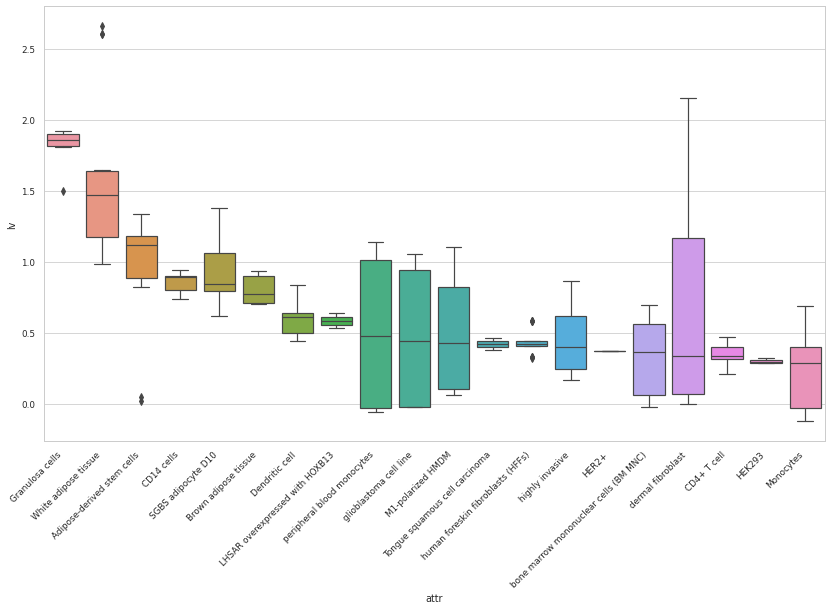

In [156]:
with sns.plotting_context("paper", font_scale=1.0), sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(14, 8))
    ax = sns.boxplot(
        data=df,
        x="attr",
        y="lv",
        order=cat_order,
        linewidth=None,
        ax=ax,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

# Tissues

In [131]:
df = pd.concat(tissue_dfs[:N_TOP_LVS], ignore_index=True)
# df = pd.concat([_get_lv_rank(x) for x in tissue_dfs[:N_TOP_LVS]], ignore_index=True)

In [132]:
df.groupby("attr").median().squeeze().sort_values(ascending=False).head(50)

attr
Muscle biopsy immediately before surgery                    0.741159
Muscle biopsy 2hr after surgery and tourniquet              0.665609
adrenal tumor                                               0.614902
Blood                                                       0.614716
cervix                                                      0.594815
skin (epidermal suction blister samples)                    0.578757
hiPSC-derived embryoid bodies                               0.575964
Dorsal Forebrain Equivalent                                 0.551810
Cervical Cancer                                             0.531926
14 day neurons                                              0.492091
Duct cells                                                  0.443782
colonic biopsy                                              0.393433
adipose                                                     0.300238
Embryonic kidney                                            0.300199
Colorectal cancer PDX        